In [64]:
import os, os.path
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
BASE_IMAGE_DIRECTORY = r"C:\Users\linke\Documents\Datasets\flowers"
TRAIN_IMAGE_DIRECTORY = os.path.join(BASE_IMAGE_DIRECTORY, "train")
VAL_IMAGE_DIRECTORY = os.path.join(BASE_IMAGE_DIRECTORY, "val")
TEST_IMAGE_DIRECTORY = os.path.join(BASE_IMAGE_DIRECTORY, "test")

# Analyse Dataset

In [65]:
classes = os.listdir(TRAIN_IMAGE_DIRECTORY) # dir is your directory path
number_classes = len(classes)
print ("Amount of classes: ", number_files)
print("class names", classes)

Amount of classes:  5
class names ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [66]:
df = sns.load_dataset('tips')
print(df)

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]


In [67]:
def plot_data(path):
    classes_images = []
    dict_classes_images = {}
    for class_name in classes:
        path_class = os.path.join(path, class_name)
        classes_images.append(len(os.listdir(path_class)))
    dict_classes_images["classes"] = classes
    dict_classes_images["amount"] = classes_images
    sns.barplot(y="amount", x="classes",data=dict_classes_images)
    plt.show()

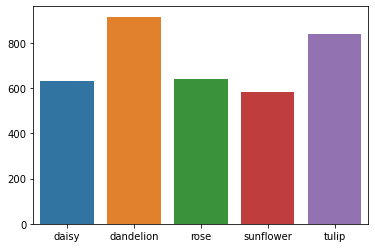

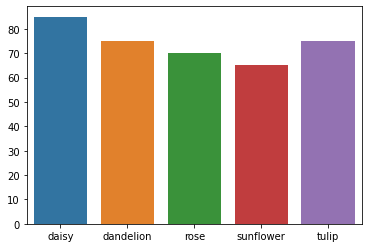

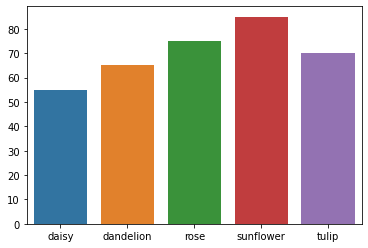

In [68]:
plot_data(TRAIN_IMAGE_DIRECTORY)
plot_data(VAL_IMAGE_DIRECTORY)
plot_data(TEST_IMAGE_DIRECTORY)

# Loading the model

In [1]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

Using TensorFlow backend.


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

# Plot example Images

FileNotFoundError: [Errno 2] No such file or directory: 'train/dog.0.jpg'

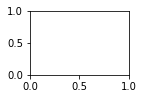

In [2]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

# Create Directories